# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 946us/sample - loss: 229.6699 - y1_output_loss: 115.1206 - y2_output_loss: 112.5571 - y1_output_root_mean_squared_error: 10.7799 - y2_output_root_mean_squared_error: 10.6520 - val_loss: 34.4567 - val_y1_output_loss: 13.0432 - val_y2_output_loss: 24.2196 - val_y1_output_root_mean_squared_error: 3.4814 - val_y2_output_root_mean_squared_error: 4.7262
Epoch 2/500
614/614 [==============================] - 0s 150us/sample - loss: 38.6926 - y1_output_loss: 13.3460 - y2_output_loss: 25.0360 - y1_output_root_mean_squared_error: 3.6678 - y2_output_root_mean_squared_error: 5.0239 - val_loss: 23.6399 - val_y1_output_loss: 10.8775 - val_y2_output_loss: 14.2941 - val_y1_output_root_mean_squared_error: 3.1803 - val_y2_output_root_mean_squared_error: 3.6777
Epoch 3/500
614/614 [==============================] - 0s 135us/sample - loss: 26.9730 - y1_output_loss: 9.9976 - y2_output_loss: 16.7248 - y1_

614/614 [==============================] - 0s 134us/sample - loss: 13.2108 - y1_output_loss: 5.0719 - y2_output_loss: 8.1360 - y1_output_root_mean_squared_error: 2.2511 - y2_output_root_mean_squared_error: 2.8536 - val_loss: 16.1679 - val_y1_output_loss: 7.4781 - val_y2_output_loss: 10.0852 - val_y1_output_root_mean_squared_error: 2.5882 - val_y2_output_root_mean_squared_error: 3.0772
Epoch 22/500
614/614 [==============================] - 0s 139us/sample - loss: 12.3311 - y1_output_loss: 4.6228 - y2_output_loss: 7.7080 - y1_output_root_mean_squared_error: 2.1578 - y2_output_root_mean_squared_error: 2.7704 - val_loss: 15.8405 - val_y1_output_loss: 7.7271 - val_y2_output_loss: 9.4775 - val_y1_output_root_mean_squared_error: 2.6179 - val_y2_output_root_mean_squared_error: 2.9978
Epoch 23/500
614/614 [==============================] - 0s 135us/sample - loss: 11.8914 - y1_output_loss: 4.7460 - y2_output_loss: 7.3228 - y1_output_root_mean_squared_error: 2.1601 - y2_output_root_mean_squared_

614/614 [==============================] - 0s 137us/sample - loss: 10.0966 - y1_output_loss: 3.0869 - y2_output_loss: 7.0055 - y1_output_root_mean_squared_error: 1.7526 - y2_output_root_mean_squared_error: 2.6505 - val_loss: 13.7022 - val_y1_output_loss: 6.9398 - val_y2_output_loss: 7.6670 - val_y1_output_root_mean_squared_error: 2.5056 - val_y2_output_root_mean_squared_error: 2.7247
Epoch 42/500
614/614 [==============================] - 0s 133us/sample - loss: 9.2572 - y1_output_loss: 2.8834 - y2_output_loss: 6.3186 - y1_output_root_mean_squared_error: 1.7052 - y2_output_root_mean_squared_error: 2.5198 - val_loss: 19.1024 - val_y1_output_loss: 6.3528 - val_y2_output_loss: 13.7914 - val_y1_output_root_mean_squared_error: 2.3944 - val_y2_output_root_mean_squared_error: 3.6564
Epoch 43/500
614/614 [==============================] - 0s 128us/sample - loss: 8.8728 - y1_output_loss: 2.7808 - y2_output_loss: 6.0560 - y1_output_root_mean_squared_error: 1.6735 - y2_output_root_mean_squared_er

Epoch 62/500
614/614 [==============================] - 0s 132us/sample - loss: 8.7557 - y1_output_loss: 2.6861 - y2_output_loss: 6.0056 - y1_output_root_mean_squared_error: 1.6455 - y2_output_root_mean_squared_error: 2.4593 - val_loss: 10.3847 - val_y1_output_loss: 3.4025 - val_y2_output_loss: 7.2925 - val_y1_output_root_mean_squared_error: 1.8321 - val_y2_output_root_mean_squared_error: 2.6510
Epoch 63/500
614/614 [==============================] - 0s 132us/sample - loss: 6.3061 - y1_output_loss: 1.8229 - y2_output_loss: 4.4258 - y1_output_root_mean_squared_error: 1.3564 - y2_output_root_mean_squared_error: 2.1133 - val_loss: 7.0715 - val_y1_output_loss: 2.8096 - val_y2_output_loss: 4.5743 - val_y1_output_root_mean_squared_error: 1.6385 - val_y2_output_root_mean_squared_error: 2.0945
Epoch 64/500
614/614 [==============================] - 0s 132us/sample - loss: 6.6811 - y1_output_loss: 2.0153 - y2_output_loss: 4.6171 - y1_output_root_mean_squared_error: 1.4250 - y2_output_root_mean_

Epoch 83/500
614/614 [==============================] - 0s 131us/sample - loss: 4.4499 - y1_output_loss: 1.3128 - y2_output_loss: 3.1250 - y1_output_root_mean_squared_error: 1.1466 - y2_output_root_mean_squared_error: 1.7707 - val_loss: 4.9371 - val_y1_output_loss: 1.6247 - val_y2_output_loss: 3.5497 - val_y1_output_root_mean_squared_error: 1.2522 - val_y2_output_root_mean_squared_error: 1.8355
Epoch 84/500
614/614 [==============================] - 0s 130us/sample - loss: 3.7795 - y1_output_loss: 1.1443 - y2_output_loss: 2.6871 - y1_output_root_mean_squared_error: 1.0548 - y2_output_root_mean_squared_error: 1.6331 - val_loss: 19.2423 - val_y1_output_loss: 5.8277 - val_y2_output_loss: 13.6142 - val_y1_output_root_mean_squared_error: 2.4309 - val_y2_output_root_mean_squared_error: 3.6514
Epoch 85/500
614/614 [==============================] - 0s 130us/sample - loss: 5.7979 - y1_output_loss: 1.6465 - y2_output_loss: 4.1280 - y1_output_root_mean_squared_error: 1.2812 - y2_output_root_mean

Epoch 104/500
614/614 [==============================] - 0s 132us/sample - loss: 2.7493 - y1_output_loss: 0.6964 - y2_output_loss: 2.0368 - y1_output_root_mean_squared_error: 0.8343 - y2_output_root_mean_squared_error: 1.4329 - val_loss: 4.8066 - val_y1_output_loss: 1.2329 - val_y2_output_loss: 3.8260 - val_y1_output_root_mean_squared_error: 1.1016 - val_y2_output_root_mean_squared_error: 1.8956
Epoch 105/500
614/614 [==============================] - 0s 141us/sample - loss: 4.8674 - y1_output_loss: 1.0315 - y2_output_loss: 3.8101 - y1_output_root_mean_squared_error: 1.0165 - y2_output_root_mean_squared_error: 1.9581 - val_loss: 2.7752 - val_y1_output_loss: 1.0301 - val_y2_output_loss: 1.9755 - val_y1_output_root_mean_squared_error: 0.9852 - val_y2_output_root_mean_squared_error: 1.3434
Epoch 106/500
614/614 [==============================] - 0s 135us/sample - loss: 2.1742 - y1_output_loss: 0.5178 - y2_output_loss: 1.6536 - y1_output_root_mean_squared_error: 0.7200 - y2_output_root_mea

614/614 [==============================] - 0s 132us/sample - loss: 3.2033 - y1_output_loss: 0.6912 - y2_output_loss: 2.4881 - y1_output_root_mean_squared_error: 0.8352 - y2_output_root_mean_squared_error: 1.5829 - val_loss: 1.9265 - val_y1_output_loss: 0.5744 - val_y2_output_loss: 1.5448 - val_y1_output_root_mean_squared_error: 0.7534 - val_y2_output_root_mean_squared_error: 1.1657
Epoch 125/500
614/614 [==============================] - 0s 130us/sample - loss: 1.6852 - y1_output_loss: 0.3620 - y2_output_loss: 1.3149 - y1_output_root_mean_squared_error: 0.5992 - y2_output_root_mean_squared_error: 1.1516 - val_loss: 2.1776 - val_y1_output_loss: 0.8328 - val_y2_output_loss: 1.5493 - val_y1_output_root_mean_squared_error: 0.8721 - val_y2_output_root_mean_squared_error: 1.1904
Epoch 126/500
614/614 [==============================] - 0s 132us/sample - loss: 2.2411 - y1_output_loss: 0.4804 - y2_output_loss: 1.7850 - y1_output_root_mean_squared_error: 0.6936 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 135us/sample - loss: 1.4935 - y1_output_loss: 0.3157 - y2_output_loss: 1.1688 - y1_output_root_mean_squared_error: 0.5627 - y2_output_root_mean_squared_error: 1.0848 - val_loss: 1.6784 - val_y1_output_loss: 0.7270 - val_y2_output_loss: 1.1098 - val_y1_output_root_mean_squared_error: 0.8340 - val_y2_output_root_mean_squared_error: 0.9914
Epoch 146/500
614/614 [==============================] - 0s 133us/sample - loss: 1.8658 - y1_output_loss: 0.3488 - y2_output_loss: 1.5009 - y1_output_root_mean_squared_error: 0.5934 - y2_output_root_mean_squared_error: 1.2303 - val_loss: 3.0802 - val_y1_output_loss: 0.6240 - val_y2_output_loss: 2.6684 - val_y1_output_root_mean_squared_error: 0.7952 - val_y2_output_root_mean_squared_error: 1.5646
Epoch 147/500
614/614 [==============================] - 0s 134us/sample - loss: 1.6756 - y1_output_loss: 0.3156 - y2_output_loss: 1.3664 - y1_output_root_mean_squared_error: 0.5540 - y2_output_root_mea

614/614 [==============================] - 0s 138us/sample - loss: 1.4885 - y1_output_loss: 0.3832 - y2_output_loss: 1.1128 - y1_output_root_mean_squared_error: 0.6183 - y2_output_root_mean_squared_error: 1.0517 - val_loss: 3.6956 - val_y1_output_loss: 0.5643 - val_y2_output_loss: 3.4189 - val_y1_output_root_mean_squared_error: 0.7594 - val_y2_output_root_mean_squared_error: 1.7661
Epoch 166/500
614/614 [==============================] - 0s 130us/sample - loss: 1.7780 - y1_output_loss: 0.3271 - y2_output_loss: 1.4989 - y1_output_root_mean_squared_error: 0.5741 - y2_output_root_mean_squared_error: 1.2035 - val_loss: 2.8024 - val_y1_output_loss: 0.4790 - val_y2_output_loss: 2.4170 - val_y1_output_root_mean_squared_error: 0.6695 - val_y2_output_root_mean_squared_error: 1.5343
Epoch 167/500
614/614 [==============================] - 0s 134us/sample - loss: 1.3159 - y1_output_loss: 0.2705 - y2_output_loss: 1.0447 - y1_output_root_mean_squared_error: 0.5131 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 131us/sample - loss: 0.9897 - y1_output_loss: 0.2122 - y2_output_loss: 0.7717 - y1_output_root_mean_squared_error: 0.4601 - y2_output_root_mean_squared_error: 0.8820 - val_loss: 0.9961 - val_y1_output_loss: 0.3148 - val_y2_output_loss: 0.8360 - val_y1_output_root_mean_squared_error: 0.5512 - val_y2_output_root_mean_squared_error: 0.8320
Epoch 187/500
614/614 [==============================] - 0s 130us/sample - loss: 1.0340 - y1_output_loss: 0.2230 - y2_output_loss: 0.8080 - y1_output_root_mean_squared_error: 0.4725 - y2_output_root_mean_squared_error: 0.9004 - val_loss: 1.1434 - val_y1_output_loss: 0.3078 - val_y2_output_loss: 0.9972 - val_y1_output_root_mean_squared_error: 0.5537 - val_y2_output_root_mean_squared_error: 0.9148
Epoch 188/500
614/614 [==============================] - 0s 132us/sample - loss: 1.8646 - y1_output_loss: 0.4266 - y2_output_loss: 1.4350 - y1_output_root_mean_squared_error: 0.6506 - y2_output_root_mea

614/614 [==============================] - 0s 131us/sample - loss: 0.9457 - y1_output_loss: 0.2211 - y2_output_loss: 0.7220 - y1_output_root_mean_squared_error: 0.4680 - y2_output_root_mean_squared_error: 0.8525 - val_loss: 1.2594 - val_y1_output_loss: 0.3640 - val_y2_output_loss: 1.0677 - val_y1_output_root_mean_squared_error: 0.6096 - val_y2_output_root_mean_squared_error: 0.9422
Epoch 207/500
614/614 [==============================] - 0s 132us/sample - loss: 0.8421 - y1_output_loss: 0.2019 - y2_output_loss: 0.6472 - y1_output_root_mean_squared_error: 0.4503 - y2_output_root_mean_squared_error: 0.7996 - val_loss: 1.7982 - val_y1_output_loss: 0.3166 - val_y2_output_loss: 1.6602 - val_y1_output_root_mean_squared_error: 0.5630 - val_y2_output_root_mean_squared_error: 1.2171
Epoch 208/500
614/614 [==============================] - 0s 133us/sample - loss: 0.9243 - y1_output_loss: 0.2042 - y2_output_loss: 0.7196 - y1_output_root_mean_squared_error: 0.4524 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 138us/sample - loss: 0.8478 - y1_output_loss: 0.1995 - y2_output_loss: 0.6494 - y1_output_root_mean_squared_error: 0.4465 - y2_output_root_mean_squared_error: 0.8053 - val_loss: 1.0077 - val_y1_output_loss: 0.3190 - val_y2_output_loss: 0.8273 - val_y1_output_root_mean_squared_error: 0.5620 - val_y2_output_root_mean_squared_error: 0.8317
Epoch 228/500
614/614 [==============================] - 0s 140us/sample - loss: 0.9566 - y1_output_loss: 0.2104 - y2_output_loss: 0.7707 - y1_output_root_mean_squared_error: 0.4555 - y2_output_root_mean_squared_error: 0.8655 - val_loss: 4.0677 - val_y1_output_loss: 0.6835 - val_y2_output_loss: 3.4847 - val_y1_output_root_mean_squared_error: 0.8059 - val_y2_output_root_mean_squared_error: 1.8488
Epoch 229/500
614/614 [==============================] - 0s 133us/sample - loss: 1.3129 - y1_output_loss: 0.2679 - y2_output_loss: 1.0413 - y1_output_root_mean_squared_error: 0.5181 - y2_output_root_mea

614/614 [==============================] - 0s 139us/sample - loss: 0.6200 - y1_output_loss: 0.1807 - y2_output_loss: 0.4599 - y1_output_root_mean_squared_error: 0.4247 - y2_output_root_mean_squared_error: 0.6630 - val_loss: 2.8635 - val_y1_output_loss: 0.4139 - val_y2_output_loss: 2.5681 - val_y1_output_root_mean_squared_error: 0.6523 - val_y2_output_root_mean_squared_error: 1.5614
Epoch 248/500
614/614 [==============================] - 0s 136us/sample - loss: 0.9507 - y1_output_loss: 0.2144 - y2_output_loss: 0.7389 - y1_output_root_mean_squared_error: 0.4645 - y2_output_root_mean_squared_error: 0.8573 - val_loss: 1.1177 - val_y1_output_loss: 0.2985 - val_y2_output_loss: 0.8650 - val_y1_output_root_mean_squared_error: 0.5462 - val_y2_output_root_mean_squared_error: 0.9052
Epoch 249/500
614/614 [==============================] - 0s 132us/sample - loss: 0.8264 - y1_output_loss: 0.2415 - y2_output_loss: 0.5900 - y1_output_root_mean_squared_error: 0.4867 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 131us/sample - loss: 0.8901 - y1_output_loss: 0.2605 - y2_output_loss: 0.6252 - y1_output_root_mean_squared_error: 0.5120 - y2_output_root_mean_squared_error: 0.7924 - val_loss: 1.0180 - val_y1_output_loss: 0.2953 - val_y2_output_loss: 0.8172 - val_y1_output_root_mean_squared_error: 0.5393 - val_y2_output_root_mean_squared_error: 0.8527
Epoch 269/500
614/614 [==============================] - 0s 130us/sample - loss: 0.7328 - y1_output_loss: 0.1904 - y2_output_loss: 0.5365 - y1_output_root_mean_squared_error: 0.4374 - y2_output_root_mean_squared_error: 0.7358 - val_loss: 0.7438 - val_y1_output_loss: 0.2667 - val_y2_output_loss: 0.5598 - val_y1_output_root_mean_squared_error: 0.5092 - val_y2_output_root_mean_squared_error: 0.6961
Epoch 270/500
614/614 [==============================] - 0s 131us/sample - loss: 0.5666 - y1_output_loss: 0.1510 - y2_output_loss: 0.4187 - y1_output_root_mean_squared_error: 0.3902 - y2_output_root_mea

614/614 [==============================] - 0s 130us/sample - loss: 0.5252 - y1_output_loss: 0.1484 - y2_output_loss: 0.3788 - y1_output_root_mean_squared_error: 0.3856 - y2_output_root_mean_squared_error: 0.6136 - val_loss: 1.9945 - val_y1_output_loss: 0.2891 - val_y2_output_loss: 1.8782 - val_y1_output_root_mean_squared_error: 0.5392 - val_y2_output_root_mean_squared_error: 1.3053
Epoch 289/500
614/614 [==============================] - 0s 135us/sample - loss: 0.5278 - y1_output_loss: 0.1617 - y2_output_loss: 0.3630 - y1_output_root_mean_squared_error: 0.4017 - y2_output_root_mean_squared_error: 0.6053 - val_loss: 0.7554 - val_y1_output_loss: 0.2640 - val_y2_output_loss: 0.6061 - val_y1_output_root_mean_squared_error: 0.5092 - val_y2_output_root_mean_squared_error: 0.7043
Epoch 290/500
614/614 [==============================] - 0s 131us/sample - loss: 0.6656 - y1_output_loss: 0.1820 - y2_output_loss: 0.4804 - y1_output_root_mean_squared_error: 0.4272 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 134us/sample - loss: 0.8958 - y1_output_loss: 0.2376 - y2_output_loss: 0.6544 - y1_output_root_mean_squared_error: 0.4889 - y2_output_root_mean_squared_error: 0.8104 - val_loss: 0.9606 - val_y1_output_loss: 0.2917 - val_y2_output_loss: 0.8095 - val_y1_output_root_mean_squared_error: 0.5391 - val_y2_output_root_mean_squared_error: 0.8185
Epoch 310/500
614/614 [==============================] - 0s 141us/sample - loss: 0.7014 - y1_output_loss: 0.1872 - y2_output_loss: 0.5182 - y1_output_root_mean_squared_error: 0.4300 - y2_output_root_mean_squared_error: 0.7187 - val_loss: 1.0211 - val_y1_output_loss: 0.3143 - val_y2_output_loss: 0.8445 - val_y1_output_root_mean_squared_error: 0.5582 - val_y2_output_root_mean_squared_error: 0.8423
Epoch 311/500
614/614 [==============================] - 0s 137us/sample - loss: 0.5420 - y1_output_loss: 0.1424 - y2_output_loss: 0.4015 - y1_output_root_mean_squared_error: 0.3789 - y2_output_root_mea

614/614 [==============================] - 0s 132us/sample - loss: 0.4980 - y1_output_loss: 0.1741 - y2_output_loss: 0.3355 - y1_output_root_mean_squared_error: 0.4135 - y2_output_root_mean_squared_error: 0.5718 - val_loss: 2.5556 - val_y1_output_loss: 0.7444 - val_y2_output_loss: 1.8916 - val_y1_output_root_mean_squared_error: 0.8501 - val_y2_output_root_mean_squared_error: 1.3538
Epoch 330/500
614/614 [==============================] - 0s 132us/sample - loss: 0.9270 - y1_output_loss: 0.2409 - y2_output_loss: 0.6786 - y1_output_root_mean_squared_error: 0.4924 - y2_output_root_mean_squared_error: 0.8274 - val_loss: 1.0358 - val_y1_output_loss: 0.4387 - val_y2_output_loss: 0.6619 - val_y1_output_root_mean_squared_error: 0.6629 - val_y2_output_root_mean_squared_error: 0.7722
Epoch 331/500
614/614 [==============================] - 0s 133us/sample - loss: 0.4430 - y1_output_loss: 0.1506 - y2_output_loss: 0.3410 - y1_output_root_mean_squared_error: 0.3821 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 132us/sample - loss: 0.4490 - y1_output_loss: 0.1534 - y2_output_loss: 0.2936 - y1_output_root_mean_squared_error: 0.3925 - y2_output_root_mean_squared_error: 0.5431 - val_loss: 1.0079 - val_y1_output_loss: 0.4254 - val_y2_output_loss: 0.6282 - val_y1_output_root_mean_squared_error: 0.6442 - val_y2_output_root_mean_squared_error: 0.7700
Epoch 351/500
614/614 [==============================] - 0s 132us/sample - loss: 0.5308 - y1_output_loss: 0.1616 - y2_output_loss: 0.3668 - y1_output_root_mean_squared_error: 0.4035 - y2_output_root_mean_squared_error: 0.6066 - val_loss: 0.9132 - val_y1_output_loss: 0.3259 - val_y2_output_loss: 0.6682 - val_y1_output_root_mean_squared_error: 0.5598 - val_y2_output_root_mean_squared_error: 0.7745
Epoch 352/500
614/614 [==============================] - 0s 129us/sample - loss: 0.4468 - y1_output_loss: 0.1544 - y2_output_loss: 0.3001 - y1_output_root_mean_squared_error: 0.3944 - y2_output_root_mea

614/614 [==============================] - 0s 136us/sample - loss: 0.4626 - y1_output_loss: 0.1582 - y2_output_loss: 0.3051 - y1_output_root_mean_squared_error: 0.3960 - y2_output_root_mean_squared_error: 0.5530 - val_loss: 0.9512 - val_y1_output_loss: 0.4787 - val_y2_output_loss: 0.5188 - val_y1_output_root_mean_squared_error: 0.6892 - val_y2_output_root_mean_squared_error: 0.6901
Epoch 371/500
614/614 [==============================] - 0s 132us/sample - loss: 0.3684 - y1_output_loss: 0.1351 - y2_output_loss: 0.2329 - y1_output_root_mean_squared_error: 0.3681 - y2_output_root_mean_squared_error: 0.4825 - val_loss: 0.8446 - val_y1_output_loss: 0.3027 - val_y2_output_loss: 0.5782 - val_y1_output_root_mean_squared_error: 0.5501 - val_y2_output_root_mean_squared_error: 0.7362
Epoch 372/500
614/614 [==============================] - 0s 133us/sample - loss: 0.4757 - y1_output_loss: 0.1634 - y2_output_loss: 0.3165 - y1_output_root_mean_squared_error: 0.3978 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4636 - y1_output_loss: 0.1639 - y2_output_loss: 0.2960 - y1_output_root_mean_squared_error: 0.4065 - y2_output_root_mean_squared_error: 0.5462 - val_loss: 0.6777 - val_y1_output_loss: 0.2496 - val_y2_output_loss: 0.4732 - val_y1_output_root_mean_squared_error: 0.4959 - val_y2_output_root_mean_squared_error: 0.6571
Epoch 392/500
614/614 [==============================] - 0s 130us/sample - loss: 0.6959 - y1_output_loss: 0.2072 - y2_output_loss: 0.4836 - y1_output_root_mean_squared_error: 0.4569 - y2_output_root_mean_squared_error: 0.6980 - val_loss: 0.8220 - val_y1_output_loss: 0.2920 - val_y2_output_loss: 0.5766 - val_y1_output_root_mean_squared_error: 0.5445 - val_y2_output_root_mean_squared_error: 0.7249
Epoch 393/500
614/614 [==============================] - 0s 131us/sample - loss: 0.3783 - y1_output_loss: 0.1246 - y2_output_loss: 0.2537 - y1_output_root_mean_squared_error: 0.3520 - y2_output_root_mea

614/614 [==============================] - 0s 133us/sample - loss: 0.3755 - y1_output_loss: 0.1444 - y2_output_loss: 0.2299 - y1_output_root_mean_squared_error: 0.3807 - y2_output_root_mean_squared_error: 0.4802 - val_loss: 0.8408 - val_y1_output_loss: 0.3007 - val_y2_output_loss: 0.5717 - val_y1_output_root_mean_squared_error: 0.5420 - val_y2_output_root_mean_squared_error: 0.7397
Epoch 412/500
614/614 [==============================] - 0s 138us/sample - loss: 0.4552 - y1_output_loss: 0.1425 - y2_output_loss: 0.3180 - y1_output_root_mean_squared_error: 0.3721 - y2_output_root_mean_squared_error: 0.5628 - val_loss: 1.0289 - val_y1_output_loss: 0.3456 - val_y2_output_loss: 0.7170 - val_y1_output_root_mean_squared_error: 0.5921 - val_y2_output_root_mean_squared_error: 0.8236
Epoch 413/500
614/614 [==============================] - 0s 132us/sample - loss: 0.3706 - y1_output_loss: 0.1406 - y2_output_loss: 0.2286 - y1_output_root_mean_squared_error: 0.3764 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 134us/sample - loss: 0.3041 - y1_output_loss: 0.1151 - y2_output_loss: 0.1904 - y1_output_root_mean_squared_error: 0.3381 - y2_output_root_mean_squared_error: 0.4357 - val_loss: 0.7437 - val_y1_output_loss: 0.3410 - val_y2_output_loss: 0.4360 - val_y1_output_root_mean_squared_error: 0.5814 - val_y2_output_root_mean_squared_error: 0.6369
Epoch 433/500
614/614 [==============================] - 0s 139us/sample - loss: 0.2810 - y1_output_loss: 0.1092 - y2_output_loss: 0.1712 - y1_output_root_mean_squared_error: 0.3316 - y2_output_root_mean_squared_error: 0.4136 - val_loss: 0.7175 - val_y1_output_loss: 0.2652 - val_y2_output_loss: 0.4998 - val_y1_output_root_mean_squared_error: 0.5113 - val_y2_output_root_mean_squared_error: 0.6753
Epoch 434/500
614/614 [==============================] - 0s 142us/sample - loss: 0.4218 - y1_output_loss: 0.1403 - y2_output_loss: 0.2844 - y1_output_root_mean_squared_error: 0.3738 - y2_output_root_mea

614/614 [==============================] - 0s 129us/sample - loss: 0.3073 - y1_output_loss: 0.1170 - y2_output_loss: 0.1894 - y1_output_root_mean_squared_error: 0.3426 - y2_output_root_mean_squared_error: 0.4358 - val_loss: 0.8211 - val_y1_output_loss: 0.2931 - val_y2_output_loss: 0.5534 - val_y1_output_root_mean_squared_error: 0.5415 - val_y2_output_root_mean_squared_error: 0.7266
Epoch 453/500
614/614 [==============================] - 0s 130us/sample - loss: 0.4055 - y1_output_loss: 0.1240 - y2_output_loss: 0.2792 - y1_output_root_mean_squared_error: 0.3528 - y2_output_root_mean_squared_error: 0.5301 - val_loss: 0.6932 - val_y1_output_loss: 0.3068 - val_y2_output_loss: 0.4324 - val_y1_output_root_mean_squared_error: 0.5518 - val_y2_output_root_mean_squared_error: 0.6235
Epoch 454/500
614/614 [==============================] - 0s 130us/sample - loss: 0.3140 - y1_output_loss: 0.1135 - y2_output_loss: 0.2029 - y1_output_root_mean_squared_error: 0.3358 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 132us/sample - loss: 0.3076 - y1_output_loss: 0.1275 - y2_output_loss: 0.1918 - y1_output_root_mean_squared_error: 0.3521 - y2_output_root_mean_squared_error: 0.4285 - val_loss: 0.7852 - val_y1_output_loss: 0.3695 - val_y2_output_loss: 0.4617 - val_y1_output_root_mean_squared_error: 0.5938 - val_y2_output_root_mean_squared_error: 0.6577
Epoch 474/500
614/614 [==============================] - 0s 137us/sample - loss: 0.5858 - y1_output_loss: 0.1887 - y2_output_loss: 0.3944 - y1_output_root_mean_squared_error: 0.4350 - y2_output_root_mean_squared_error: 0.6297 - val_loss: 0.6375 - val_y1_output_loss: 0.2528 - val_y2_output_loss: 0.4254 - val_y1_output_root_mean_squared_error: 0.5009 - val_y2_output_root_mean_squared_error: 0.6217
Epoch 475/500
614/614 [==============================] - 0s 136us/sample - loss: 0.2780 - y1_output_loss: 0.1124 - y2_output_loss: 0.1635 - y1_output_root_mean_squared_error: 0.3365 - y2_output_root_mea

614/614 [==============================] - 0s 131us/sample - loss: 0.3118 - y1_output_loss: 0.1131 - y2_output_loss: 0.1966 - y1_output_root_mean_squared_error: 0.3379 - y2_output_root_mean_squared_error: 0.4446 - val_loss: 0.6195 - val_y1_output_loss: 0.2460 - val_y2_output_loss: 0.4105 - val_y1_output_root_mean_squared_error: 0.4912 - val_y2_output_root_mean_squared_error: 0.6150
Epoch 494/500
614/614 [==============================] - 0s 138us/sample - loss: 0.2927 - y1_output_loss: 0.1117 - y2_output_loss: 0.1808 - y1_output_root_mean_squared_error: 0.3324 - y2_output_root_mean_squared_error: 0.4269 - val_loss: 0.6987 - val_y1_output_loss: 0.2622 - val_y2_output_loss: 0.4583 - val_y1_output_root_mean_squared_error: 0.5187 - val_y2_output_root_mean_squared_error: 0.6554
Epoch 495/500
614/614 [==============================] - 0s 130us/sample - loss: 0.3222 - y1_output_loss: 0.1157 - y2_output_loss: 0.2050 - y1_output_root_mean_squared_error: 0.3404 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 38us/sample - loss: 0.6736 - y1_output_loss: 0.2129 - y2_output_loss: 0.4565 - y1_output_root_mean_squared_error: 0.4638 - y2_output_root_mean_squared_error: 0.6771
Loss = 0.6736357374624773, Y1_loss = 0.2129349261522293, Y1_mse = 0.4638154208660126, Y2_loss = 0.45649662613868713, Y2_mse = 0.6771343946456909


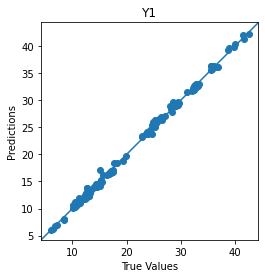

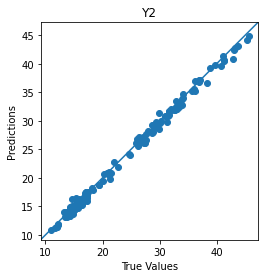

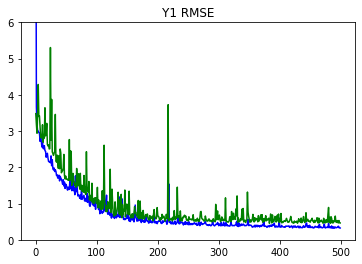

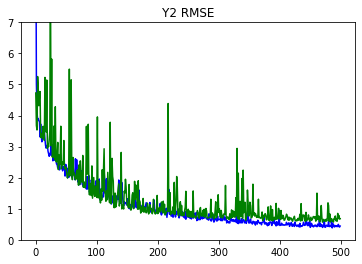

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)